# Evaluation: RAG Performance on the EU AI Act

## Overview

This notebook evaluates the retrieval accuracy and generation quality of a RAG system designed to answer questions regarding the EU AI Act. We compare performance across two variables:

1. **Conversation Complexity:** Single-turn (one-off questions) vs. Multi-turn (ongoing dialogues).
2. **Retrieval Strategy:** Standard retrieval vs. Retrieval enhanced with a Cross-Encoder Reranker.

## Summary of Results

| Evaluation Scenario | Total Queries | Retrieval Hit Rate | Avg. RAG Score (/10) | Avg. Baseline (/10) |
| --- | --- | --- | --- | --- |
| **Single Turn** | 747 | 92.8% | 8.27 | 5.56 |
| **Single Turn (Reranked)** | 747 | **96.4%** | **8.39** | 5.38 |
| **Multi-Turn** | 228 | 72.4% | 7.30 | 6.59 |
| **Multi-Turn (Reranked)** | 228 | **75.9%** | **7.51** | 6.61 |


**Evaluation Disclaimer:**
The quality scores presented in this evaluation (ranging from 1 to 10) were generated using an **LLM-as-a-Judge** framework. This automated process assesses and compares the responses from both the **Baseline** (LLM only) and the **RAG pipeline** against a predefined **Ground Truth** (the correct legal reference from the AI Act) to determine accuracy, relevance, and completeness.



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

project_root = Path.cwd().parent 

def load_processed_data(file_path, is_multi=False):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    if is_multi:
        df['Retrieval Status'] = df['is_hit'].map({True: 'Success', False: 'Fail'})
    else:
        df['Retrieval Status'] = df['hit_rank'].apply(lambda x: 'Success' if x > 0 else 'Fail')
    
    return df
single_path= project_root / "results/rag_eval_full_single_queries_20260112_200932.json" 
single_reranked_path= project_root / "results/rag_eval_full_single_turn_reranked_20260113_020921.json" 

multi_path  = project_root / "results/rag_eval_full_multi_turn_20260112_211633.json" 
multi_reranked_path  = project_root / "results/rag_eval_full_multi_turn_reranked_20260113_110602.json" 

df_single = load_processed_data(single_path, is_multi=False)
df_multi = load_processed_data(multi_path, is_multi=True)
df_single_reranked = load_processed_data(single_reranked_path, is_multi=False)
df_multi_reranked = load_processed_data(multi_reranked_path, is_multi=True)

## Data Interpretation

### 1. The Impact of Reranking

Across both single and multi-turn datasets, the **Reranking approach consistently outperforms** the standard RAG setup.

* **Retrieval Boost:** In single-turn queries, reranking reduced retrieval failures by 50% (from 54 failures down to 27), pushing the hit rate to an impressive **96.4%**.
* **Quality Gain:** The average RAG score increased in both scenarios when reranking was applied. This suggests that the Cross-Encoder better identifies the most relevant legal context, leading to more accurate and nuanced answers.

### 2. Single Turn vs. Multi-Turn Performance

There is a noticeable performance gap between single-turn and multi-turn conversations:

* **Retrieval Challenge:** The retrieval hit rate drops by approximately 20% in multi-turn settings. This is likely due to the complexity of maintaining context over time and "query drift," where the user's follow-up questions become more specific or rely heavily on previous turns.
* **Generation Quality:** RAG scores remain healthy (~7.5) in multi-turn sessions but are lower than single-turn scores (~8.3). However, even in complex dialogues, the RAG system significantly outperforms the baseline (LLM without RAG).


In [ ]:
def generate_summary(df, label):
    total = len(df)
    successes = len(df[df['Retrieval Status'] == 'Success'])
    fails = len(df[df['Retrieval Status'] == 'Fail'])
    hit_rate = (successes / total) * 100
    
    print(f"--- Summary for {label} ---")
    print(f"Total Queries:       {total}")
    print(f"Retrieval Hits:      {successes}")
    print(f"Retrieval Fails:     {fails}")
    print(f"Retrieval Hit Rate:  {hit_rate:.1f}%")
    print(f"Avg. RAG Score:      {df['rag_score'].mean():.2f} / 10.0")
    print(f"Avg. Baseline Score: {df['baseline_score'].mean():.2f} / 10.0\n")

generate_summary(df_single, "Single Turn")
generate_summary(df_multi, "Multi Turn")
generate_summary(df_single, "Single Turn")
generate_summary(df_multi, "Multi Turn")

--- Summary for Single Turn ---
Total Queries:       747
Retrieval Hits:      693
Retrieval Fails:     54
Retrieval Hit Rate:  92.8%
Avg. RAG Score:      8.27 / 10.0
Avg. Baseline Score: 5.56 / 10.0

--- Summary for Multi Turn ---
Total Queries:       228
Retrieval Hits:      165
Retrieval Fails:     63
Retrieval Hit Rate:  72.4%
Avg. RAG Score:      7.30 / 10.0
Avg. Baseline Score: 6.59 / 10.0

--- Summary for Single Turn Reranked ---
Total Queries:       747
Retrieval Hits:      720
Retrieval Fails:     27
Retrieval Hit Rate:  96.4%
Avg. RAG Score:      8.39 / 10.0
Avg. Baseline Score: 5.38 / 10.0

--- Summary for Multi Turn Reranked ---
Total Queries:       228
Retrieval Hits:      173
Retrieval Fails:     55
Retrieval Hit Rate:  75.9%
Avg. RAG Score:      7.51 / 10.0
Avg. Baseline Score: 6.61 / 10.0



### 3. Conversation Decay

The "Conversation Decay" visualizations illustrate how performance evolves for both the RAG system and the baseline as a dialogue progresses. 

---

#### **Standard RAG Pipeline**

* **RAG Performance Trend:** The standard RAG system starts with its highest quality score at Turn 1 (~8.1). However, it experiences a consistent decline through the subsequent turns, ending at its lowest point in Turn 4 (~6.5). This "decay" highlights the challenge of retrieval in multi-turn settings, where follow-up questions often become more ambiguous or context-dependent, making it harder to fetch the exact required clause from the AI Act.
* **Baseline Performance Trend:** The baseline (LLM-only) starts significantly lower (~5.4) but shows an upward trend through Turn 3. This is likely due to "conversational momentum": as the LLM's history buffer fills with its own previous reasoning, it can sometimes refine its logic or appear more focused on the topic, even without new external data.



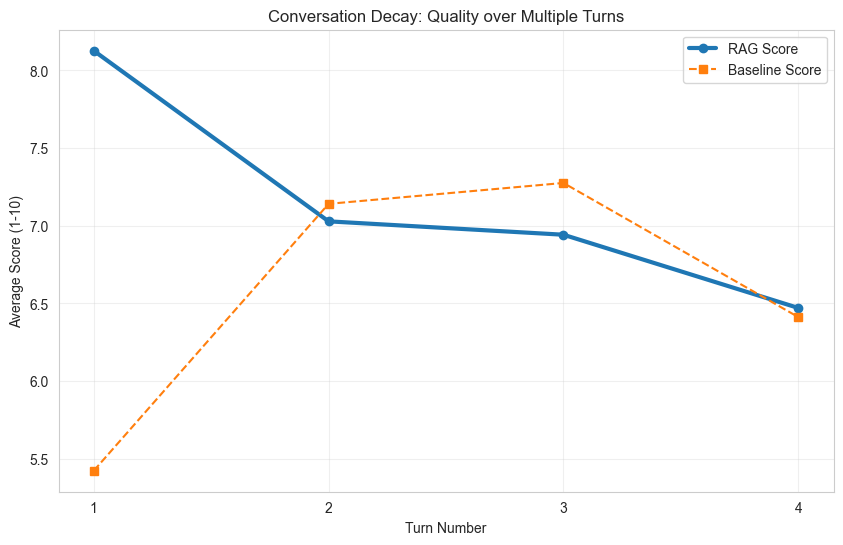

In [6]:
plt.figure(figsize=(10, 6))
decay = df_multi.groupby('turn_number')[['rag_score', 'baseline_score']].mean().reset_index()

plt.plot(decay['turn_number'], decay['rag_score'], label='RAG Score', marker='o', linewidth=3)
plt.plot(decay['turn_number'], decay['baseline_score'], label='Baseline Score', marker='s', linestyle='--')

plt.title("Conversation Decay: Quality over Multiple Turns")
plt.xlabel("Turn Number")
plt.ylabel("Average Score (1-10)")
plt.xticks(decay['turn_number'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### **Reranked RAG Pipeline**

* **Performance Recovery:** In contrast to the standard pipeline, the **Reranked RAG** system shows more resilience. While it also sees an initial dip in Turn 2, the score **recovers by Turn 4 (~7.8)**.
* **The Reranking Advantage:** This recovery suggests that the Cross-Encoder Reranker is more effective at navigating "messy" multi-turn queries. 
* **Converging vs. Sustained Quality:** While the baseline and RAG scores eventually converge in the standard pipeline, the Reranked version maintains a clear "quality gap" over the baseline.


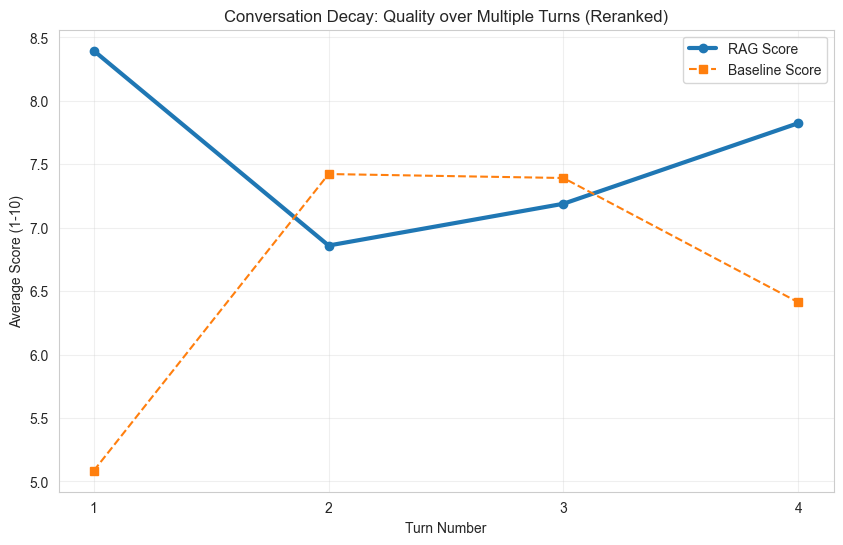

In [14]:
plt.figure(figsize=(10, 6))
decay = df_multi_reranked.groupby('turn_number')[['rag_score', 'baseline_score']].mean().reset_index()

plt.plot(decay['turn_number'], decay['rag_score'], label='RAG Score', marker='o', linewidth=3)
plt.plot(decay['turn_number'], decay['baseline_score'], label='Baseline Score', marker='s', linestyle='--')

plt.title("Conversation Decay: Quality over Multiple Turns (Reranked)")
plt.xlabel("Turn Number")
plt.ylabel("Average Score (1-10)")
plt.xticks(decay['turn_number'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4. Analysis: Impact of Retrieval on Generation

A critical part of this evaluation is understanding the **correlation between retrieval and generation**. The chart above illustrates the "RAG Lift"—the measurable value added by grounding the model in the actual text of the law.

* **The "Fall-back" Effect:** When retrieval fails (red bars), the RAG score drops significantly, effectively falling back to the performance level of the Baseline LLM (~5.5). This proves that the LLM alone does not have enough specific knowledge of the AI Act to provide high-quality legal answers.
* **Success:** A successful retrieval event (green bars) boosts the answer quality from roughly 5.5 to 8.5.
* **Strict Evaluation & Error Bars:** It is important to note that our "hit" criteria for correct citation is quite strict. Due to document overlap and hierarchical flattening in the data processing stage, information is often spread across multiple chunks. This means the model can often synthesize correct answers from related context available in other retrieved segments.

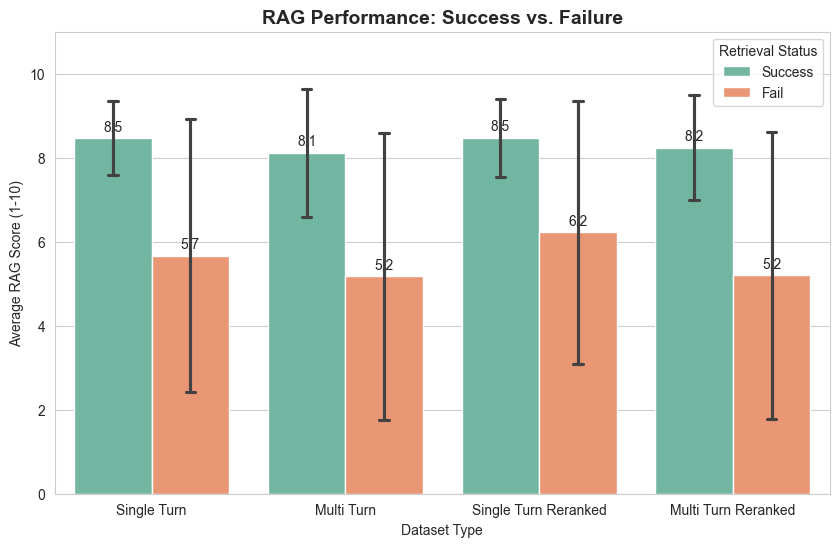

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

combined = pd.concat([
    df_single.assign(Dataset='Single Turn'),
    df_multi.assign(Dataset='Multi Turn'),
    df_single_reranked.assign(Dataset='Single Turn Reranked'),
    df_multi_reranked.assign(Dataset='Multi Turn Reranked')
])
plt.figure(figsize=(10, 6))

sns.barplot(
    data=combined, 
    x='Dataset', 
    y='rag_score', 
    hue='Retrieval Status', 
    palette='Set2',
    capsize=.1,
    errorbar="sd" 
)

plt.title("RAG Performance: Success vs. Failure", fontsize=14, fontweight='bold')
plt.ylabel("Average RAG Score (1-10)")
plt.xlabel("Dataset Type")
plt.ylim(0, 11)
plt.legend(title="Retrieval Status", loc='upper right')

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f', padding=3)

plt.show()